## Webscraping and API Calls

In [2]:
# import dependencies
import numpy as np
import pandas as pd
import datetime as dt
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
from selenium import webdriver
import time
import random
import spotipy
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Fix the constant portion of the url

url = 'https://spotifycharts.com/regional'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'html.parser')

In [100]:
# This is the code to scrape tracks from spotify charts

song_dict = defaultdict(int)

for each_track in soup.find_all(class_ = 'chart-table-track'):
        title = each_track.find('strong')
        artist = each_track.find('span')
        if title != None or artist != None:
            song_dict[(title.text, artist.text.replace("by", ""))] += 1


In [ ]:
# Collect all info at once

for each_track in soup.find_all('tr')[1:]:
    title = each_track.find('strong').text
    artist = each_track.find('span').text.replace("by", "")
    track_id = each_track.find('a')['href'][31:]
    stream_count = int(each_track.find( class_ = 'chart-table-streams').decode_contents(formatter="html").replace(",", ""))
    print(title, artist, track_id, stream_count)

In [ ]:
# Define range of variable

end_date = dt.datetime.strptime("2019-10-12", "%Y-%m-%d")
start_date = dt.datetime.strptime("2019-01-01", "%Y-%m-%d")
date_values = [start_date + dt.timedelta(days = x) for x in range(0, (end_date-start_date).days)]
full_version = lambda x: url+

In [112]:
# This is a function to scrape tracks from spotify charts

def spotify_chart(start_date, end_date, url):
    '''
    inputs (str): scrapes tracks from Spotify viral charts by 
    takeing in start_date and end_date with format YYYY-MM-DD
    
    
    outputs (dict): returns a dictonary with
    each combination of 'track_id', 'title', and 'artist' as a key; and
    no. of times the track appears in top 50 viral chart
    as value for the period.
    '''
    
    base_url = url
    
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    
    dates = [start_date + dt.timedelta(days = x) for x in range(0, 1+(end_date-start_date).days,7)]

    full_version = lambda x: url+x

    song_dict = defaultdict(int)
    
    counter = 0 
    
    for each_date in dates:
        counter += 1
        if counter % 5 == 0:
            time.sleep(random.randint(1,6))
            print(counter, "weeks' worth of data scraped")
        full_url = base_url + each_date.date().__str__() + '--' + (each_date.date() + dt.timedelta(days = 7)).__str__()
        response = requests.get(full_url)
        page = response.text
        soup = BeautifulSoup(page, 'html.parser')
        
        for each_track in soup.find_all('tr')[1:]:
            title = each_track.find('strong').text
            artist = each_track.find('span').text.replace("by", "")
            track_id = each_track.find('a')['href'][31:]
            stream_count = int(each_track.find( class_ = 'chart-table-streams').decode_contents(formatter="html").replace(",", ""))
            song_dict[(track_id, title, artist)] = stream_count

        
        
        
    return song_dict

In [ ]:
# Get stream count of tracks

song_dict = spotify_chart(start_date = '2019-09-13', end_date = '2019-10-11', url = 'https://spotifycharts.com/regional/global/weekly/')

In [93]:
# Use spotify API with spotipy library


with open('/home/thedatacurious/Documents/Metis/spotify.txt') as f:
    content = f.readlines()
    content = [x.strip() for x in content]

client_id = content[0]
secret = content[1]

from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id = client_id, client_secret = secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


In [114]:
# This is a function to extract a song features using spotify API

def extract_features(song_dict):
    '''
    inputs (dict): takes in dictionary 'track_id', 'title', and 'artist' key 
    use 'track_id' to call spotify api for attributes
    
    outputs (dataframe): returns a dataframe with track attributes as columns
    '''
    
    counter = 0
    tracks_list_wfeatures = list()
    release_date = list()

    for key in song_dict.keys():
        counter += 1
        track_id = key[0]
        if counter % 100 == 0:
            print(len(song_dict.keys())-counter, ' tracks left')
            time.sleep(30)
        a_track_features = sp.audio_features(track_id)[0]
        date = sp.track(track_id)['album']['release_date']
        if a_track_features == None or date == None:
            continue
        else:
            tracks_list_wfeatures.append(a_track_features)
            release_date.append(date)

    df = pd.DataFrame(tracks_list_wfeatures)
    df['release_date'] = release_date
    
    return df

In [29]:
test = {('6v3KW9xbzN5yKLt9YKDYA2', 'Señorita', ' Shawn Mendes', 2019): 32898929}
extract_features(test)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,release_date
0,0.759,0.548,9,-6.049,0,0.029,0.0392,0,0.0828,0.749,116.967,audio_features,6v3KW9xbzN5yKLt9YKDYA2,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,https://api.spotify.com/v1/tracks/6v3KW9xbzN5y...,https://api.spotify.com/v1/audio-analysis/6v3K...,190800,4,2019-06-19


In [ ]:
df = pd.DataFrame(song_dict.items(), columns = ['tup', 'chart_appearances'])
df[['track_id', 'title', 'artist']] = pd.DataFrame(df.iloc[:,0].tolist())
df.drop(columns = 'tup', inplace = True)

In [ ]:
df2 = extract_features(song_dict)
full_df = df.merge(df2, left_on='track_id', right_on='id')

In [113]:
## Test all functions

# Get full year's worth of tracks on viral charts/top charts

url = 'https://spotifycharts.com/regional/global/weekly/'

song_dict = spotify_chart(start_date = '2016-12-23', end_date = '2019-10-11', url = url)

# Get first dataframe from results

df = pd.DataFrame(song_dict.items(), columns = ['tup', 'stream_count'])

# Because the initial dataframe provides a tuple of multiple variables 
#in the first column called 'tup', we recast the tuple as list so that 
# each value has its own column

df[['track_id', 'title', 'artist']] = pd.DataFrame(df.iloc[:,0].tolist())

# Drop the 'tup' column

df.drop(columns = 'tup', inplace = True)

5 weeks' worth of data scraped
10 weeks' worth of data scraped
15 weeks' worth of data scraped
20 weeks' worth of data scraped
25 weeks' worth of data scraped
30 weeks' worth of data scraped
35 weeks' worth of data scraped
40 weeks' worth of data scraped
45 weeks' worth of data scraped
50 weeks' worth of data scraped
55 weeks' worth of data scraped
60 weeks' worth of data scraped
65 weeks' worth of data scraped
70 weeks' worth of data scraped
75 weeks' worth of data scraped
80 weeks' worth of data scraped
85 weeks' worth of data scraped
90 weeks' worth of data scraped
95 weeks' worth of data scraped
100 weeks' worth of data scraped
105 weeks' worth of data scraped
110 weeks' worth of data scraped
115 weeks' worth of data scraped
120 weeks' worth of data scraped
125 weeks' worth of data scraped
130 weeks' worth of data scraped
135 weeks' worth of data scraped
140 weeks' worth of data scraped
145 weeks' worth of data scraped


In [115]:
# Get track attributes as a second dataframe 

df2 = extract_features(song_dict)

2754  tracks left
2654  tracks left
2554  tracks left
2454  tracks left
2354  tracks left
2254  tracks left
2154  tracks left
2054  tracks left
1954  tracks left
1854  tracks left
1754  tracks left
1654  tracks left
1554  tracks left
1454  tracks left
1354  tracks left
1254  tracks left
1154  tracks left
1054  tracks left
954  tracks left
854  tracks left
754  tracks left
654  tracks left
554  tracks left
454  tracks left
354  tracks left
254  tracks left
154  tracks left
54  tracks left


In [116]:
# Merge dataframes

df = df.merge(df2, left_on = 'track_id', right_on = 'id')

## Some quick initial cleaning - check for duplicates and drop them

In [126]:
# Check for duplicates

print(df.shape)
print(len(df.title.unique()))

(2852, 23)
2366


In [162]:
df[df.title == 'Believer']

,stream_count,track_id,title,artist,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,release_date
296,6770886,0CcQNd8CINkwQfe1RDtGV6,Believer,Imagine Dragons,0.779,0.787,10,-4.305,0,0.108,...,0.708,124.982,audio_features,0CcQNd8CINkwQfe1RDtGV6,spotify:track:0CcQNd8CINkwQfe1RDtGV6,https://api.spotify.com/v1/tracks/0CcQNd8CINkw...,https://api.spotify.com/v1/audio-analysis/0CcQ...,204347,4,2017-06-23
526,10287248,6VRghJeP6I0w1KxkdWFfIh,Believer,Imagine Dragons,0.770,0.787,10,-4.402,0,0.113,...,0.699,125.013,audio_features,6VRghJeP6I0w1KxkdWFfIh,spotify:track:6VRghJeP6I0w1KxkdWFfIh,https://api.spotify.com/v1/tracks/6VRghJeP6I0w...,https://api.spotify.com/v1/audio-analysis/6VRg...,203782,4,2017-01-31
1105,6839256,1NtIMM4N0cFa1dNzN15chl,Believer,Imagine Dragons,0.772,0.780,10,-4.288,0,0.108,...,0.719,124.988,audio_features,1NtIMM4N0cFa1dNzN15chl,spotify:track:1NtIMM4N0cFa1dNzN15chl,https://api.spotify.com/v1/tracks/1NtIMM4N0cFa...,https://api.spotify.com/v1/audio-analysis/1NtI...,204347,4,2017-06-23
1117,6724043,7Izh7zLJGw1Nscd62Exxj4,Believer,Imagine Dragons,0.762,0.787,10,-4.311,0,0.127,...,0.691,125.067,audio_features,7Izh7zLJGw1Nscd62Exxj4,spotify:track:7Izh7zLJGw1Nscd62Exxj4,https://api.spotify.com/v1/tracks/7Izh7zLJGw1N...,https://api.spotify.com/v1/audio-analysis/7Izh...,204347,4,2017-06-23
1511,6986327,5VKSZDsidOFHrtlJb33Syo,Believer,Imagine Dragons,0.784,0.780,10,-4.275,0,0.102,...,0.722,124.953,audio_features,5VKSZDsidOFHrtlJb33Syo,spotify:track:5VKSZDsidOFHrtlJb33Syo,https://api.spotify.com/v1/tracks/5VKSZDsidOFH...,https://api.spotify.com/v1/audio-analysis/5VKS...,204347,4,2017-06-23
1566,6850819,0pqnGHJpmpxLKifKRmU6WP,Believer,Imagine Dragons,0.776,0.780,10,-4.374,0,0.128,...,0.666,124.949,audio_features,0pqnGHJpmpxLKifKRmU6WP,spotify:track:0pqnGHJpmpxLKifKRmU6WP,https://api.spotify.com/v1/tracks/0pqnGHJpmpxL...,https://api.spotify.com/v1/audio-analysis/0pqn...,204347,4,2017-06-23


In [160]:
# Drop duplicates, retain track observation that's most recently on the chart

new_df = df.drop_duplicates(subset = ['title', 'artist'], keep = 'last')
new_df = new_df.reset_index(drop = True)
len(new_df)

2424

In [148]:
new_df.title.value_counts().head(5)

Paradise        4
Estamos Bien    3
Famous          3
Sober           3
All Night       2
Name: title, dtype: int64

In [150]:
new_df[new_df.title == 'Sober']

,stream_count,track_id,title,artist,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,release_date
562,5131062,2mNbgyi0gori4b1rFSPgIb,Sober,Lorde,0.795,0.488,6,-10.349,1,0.192,...,0.528,107.734,audio_features,2mNbgyi0gori4b1rFSPgIb,spotify:track:2mNbgyi0gori4b1rFSPgIb,https://api.spotify.com/v1/tracks/2mNbgyi0gori...,https://api.spotify.com/v1/audio-analysis/2mNb...,197236,4,2017-06-16
947,3864901,3qk4wRMDlaeagZGjSYbsOV,Sober,G-Eazy,0.558,0.766,6,-5.953,0,0.231,...,0.182,96.281,audio_features,3qk4wRMDlaeagZGjSYbsOV,spotify:track:3qk4wRMDlaeagZGjSYbsOV,https://api.spotify.com/v1/tracks/3qk4wRMDlaea...,https://api.spotify.com/v1/audio-analysis/3qk4...,203960,4,2017-12-15
1472,4151747,0STK94RxUulYqWzwFlyAb5,Sober,Demi Lovato,0.397,0.303,1,-10.413,1,0.110,...,0.170,170.220,audio_features,0STK94RxUulYqWzwFlyAb5,spotify:track:0STK94RxUulYqWzwFlyAb5,https://api.spotify.com/v1/tracks/0STK94RxUulY...,https://api.spotify.com/v1/audio-analysis/0STK...,197893,3,2018-06-21


In [161]:
# Get genres from google search using Selenium

driver = webdriver.Firefox()
hit_genres = list()


for i in new_df.index:
    search_text = "genre {} {}".format(new_df.title[i],new_df.artist[i]).replace(" ", "+")
    try:
        driver.get('https://www.google.com.np/#q='+ search_text)
        page_source = driver.page_source
        soup = BeautifulSoup(page_source, 'html.parser')
        element = soup.find(class_ = 'Z0LcW')
        if element == None:
            new_element = soup.find_all(class_ = 'title')
            sub_element = list()
            for one in new_element:
                if one.text.lower() not in new_df.title[i].lower():
                    sub_element.append(one.text)
            if sub_element != list():
                hit_genres.append(sub_element)
                print(i, sub_element)
            else:
                hit_genres.append(np.nan)
                print(i, "NONE")  
        else:
            hit_genres.append(element.text)
            print(i, element.text)
        time.sleep(random.randint(1,8)) 
    except:
            hit_genres.append(np.nan)
            print(i, "TimeoutException")

0 Dance/Electronic
1 ['Dance music', 'Dance/Electronic']
2 Dance/Electronic
3 Pop
4 Hip-Hop/Rap
5 Electropop
6 Hip-Hop/Rap
7 ['Funk', 'Contemporary R&B', 'Post-disco', 'Pop']
8 ['Pop music', 'Pop']
9 Seasonal
10 ['Pop music', 'Disco']
11 ['Electropop', 'House', 'Dance/Electronic', 'Pop']
12 ['Future bass', 'Electronica', 'House', 'Dance/Electronic', 'Pop']
13 NONE
14 Pop
15 ['Reggae fusion', 'Pop']
16 Dance/Electronic
17 Pop
18 Hip-Hop/Rap
19 Pop-rap
20 Pop
21 Dance/Electronic
22 ['Rap rock', 'Alternative/Indie']
23 Dance/Electronic
24 ['Trap music', 'Dance/Electronic']
25 Pop
26 Pop
27 R&B/Soul
28 Pop
29 Dance/Electronic
30 Dance/Electronic
31 ['Tropical house', 'Pop']
32 Dance/Electronic
33 ['Seasonal', 'Vocal/Easy Listening', 'Pop', "It's Beginning to Look Like Christmas"]
34 Pop
35 R&B/Soul
36 Pop
37 Seasonal
38 Pop
39 Hip-Hop/Rap
40 Hip-Hop/Rap
41 ['Singer-Songwriter', 'Contemporary R&B']
42 Pop
43 Reggaeton
44 ['Alternative rock', 'Electropop', 'Reggae fusion', 'Alternative/Indie

In [280]:
new_df['genre'] = pd.Series(hit_genres)

In [299]:
new_df.info()
new_df.to_csv('../data/interim/top200_all_hits.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 24 columns):
stream_count        2424 non-null int64
track_id            2424 non-null object
title               2424 non-null object
artist              2424 non-null object
danceability        2424 non-null float64
energy              2424 non-null float64
key                 2424 non-null int64
loudness            2424 non-null float64
mode                2424 non-null int64
speechiness         2424 non-null float64
acousticness        2424 non-null float64
instrumentalness    2424 non-null float64
liveness            2424 non-null float64
valence             2424 non-null float64
tempo               2424 non-null float64
type                2424 non-null object
id                  2424 non-null object
uri                 2424 non-null object
track_href          2424 non-null object
analysis_url        2424 non-null object
duration_ms         2424 non-null int64
time_signature      2424 no

In [261]:
# See if 'genre' rows with np.nan can be filled 

new_df[new_df.genre.isnull()].head()

,stream_count,track_id,title,artist,danceability,energy,key,loudness,mode,speechiness,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,release_date,genre
13,3443213,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,0.670,0.838,0,-4.031,1,0.0362,...,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4,2016-10-14,NaN
55,3159428,7vRriwrloYVaoAe3a9wJHe,"i hate u, i love u (feat. olivia o'brien)",gnash,0.492,0.275,6,-13.400,0,0.3000,...,92.600,audio_features,7vRriwrloYVaoAe3a9wJHe,spotify:track:7vRriwrloYVaoAe3a9wJHe,https://api.spotify.com/v1/tracks/7vRriwrloYVa...,https://api.spotify.com/v1/audio-analysis/7vRr...,251034,4,2016-03-25,NaN
57,2970256,4tCtwWceOPWzenK2HAIJSb,Work from Home (feat. Ty Dolla $ign),Fifth Harmony,0.803,0.585,8,-5.861,1,0.0432,...,105.017,audio_features,4tCtwWceOPWzenK2HAIJSb,spotify:track:4tCtwWceOPWzenK2HAIJSb,https://api.spotify.com/v1/tracks/4tCtwWceOPWz...,https://api.spotify.com/v1/audio-analysis/4tCt...,214480,4,2016-05-27,NaN
81,4329839,2wDjpPW3HZdA9quPPmZAMu,Trust Nobody (feat. Selena Gomez & Tory Lanez),Cashmere Cat,0.420,0.636,10,-7.216,1,0.2200,...,156.104,audio_features,2wDjpPW3HZdA9quPPmZAMu,spotify:track:2wDjpPW3HZdA9quPPmZAMu,https://api.spotify.com/v1/tracks/2wDjpPW3HZdA...,https://api.spotify.com/v1/audio-analysis/2wDj...,215670,5,2017-04-28,NaN
90,3910440,4ckuS4Nj4FZ7i3Def3Br8W,Sneakin’,Drake,0.804,0.560,8,-6.682,1,0.1850,...,85.023,audio_features,4ckuS4Nj4FZ7i3Def3Br8W,spotify:track:4ckuS4Nj4FZ7i3Def3Br8W,https://api.spotify.com/v1/tracks/4ckuS4Nj4FZ7...,https://api.spotify.com/v1/audio-analysis/4cku...,251333,4,2016-10-24,NaN


In [214]:
# As an alternative, assign genre by artist. 
# Scrape list of hip hop artists from wikipedia

hiphop_artists = list()

url = 'https://en.wikipedia.org/wiki/List_of_hip_hop_musicians'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'html.parser')

for each_section in soup.find_all('ul')[2:]:
    for artist in each_section.find_all('li'):
        hiphop_artists.append(artist.text)
        
hiphop_artists = [i.strip().replace('-', '').replace('.', '').lower() for i in hiphop_artists]

In [231]:
def is_hiphop(artist):
    test_artist = artist.strip().replace('-', '').replace('.', '').lower()
    return test_artist in hiphop_artists

genre_unknown = new_df[new_df.genre.isnull()]
        
genre_known = genre_unknown[genre_unknown.apply(lambda x: is_hiphop(x.artist), axis = 1)]

genre_known = genre_known.assign(genre = 'Hip-Hop')

In [295]:
# Retain only rows with hit-hop labels from initial dataframe, making sure that genre labels in lists get detected too

hit_genres2 = [str(i) for i in hit_genres]
new_df['genre'] = pd.Series(hit_genres2)

hiphop = new_df[new_df.genre.str.lower().str.contains('hip-hop') | new_df.genre.str.lower().str.contains('hip hop')]

# Append 'genre-known' subset with hip-hop labels to hiphop dataframe

hiphop = hiphop.append(genre_known, ignore_index = True).reset_index(drop = True)

In [297]:
# Get the shape of the dataset
hiphop.shape

(893, 24)

In [298]:
hiphop.to_csv('../data/interim/top200_hiphop.csv', index = False)

In [301]:
# Add in feature: Was the track's artist one of the top artists the year before?

# Get year of track release
release_date2 = list()
years = list()
for i in hiphop.release_date:
    year = i[:4]
    release_date2.append((int(year)))
    
hiphop = hiphop.assign(release_year = release_date2)

In [3]:
hiphop = pd.read_csv('../data/interim/top200_hiphop.csv')

In [303]:
# Write function to get collection of top hip hop artists from Billboard charts for any given year



def top_artists(years):
    top_artists_dict = dict()
    for year in years:
        artists_list = list()
        url = 'https://www.billboard.com/charts/year-end/' + str(year) + '/top-r-and-b-hip-hop-artists'
        #print(url)
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page, 'html.parser')

        for each_artist in soup.find_all(class_ = 'ye-chart-item__title'):
            artist = each_artist.find('a')
            if artist != None:
                artists_list.append(artist.text.replace('\n', '').replace('-', '').replace('.', '').lower())
                #print(artist.text)
        
        top_artists_dict[year] = artists_list
        time.sleep(random.randint(2,8))
        print(year, 'is done')
    return top_artists_dict

In [28]:
# Write function to get collection of top hip hop artists AND SCORING based on billboard position


def top_artists(years):
    top_artists_dict = dict()
    for year in years:
        year_dict = dict()
        url = 'https://www.billboard.com/charts/year-end/' + str(year) + '/top-r-and-b-hip-hop-artists'
        #print(url)
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page, 'html.parser')
        
        counter = 0
        for each_artist in soup.find_all(class_ = 'ye-chart-item__title'):
            counter += 1
            artist = each_artist.find('a')
            if artist != None:
                artist = artist.text.replace('\n', '').replace('-', '').replace('.', '').lower()
                score = 51 - counter
                year_dict[artist] = score
                #print(artist, score)
        
        top_artists_dict[year] = year_dict
        time.sleep(random.randint(2,8))
        print(year, 'is done')
    return top_artists_dict

In [29]:
# Extract tracks' release years and run top_artist_dict function 

years = hiphop.release_year.unique().tolist()
prev_years = [year -1 for year in years ]
top_artists_dict = top_artists(prev_years)

2015 is done
2016 is done
2014 is done
2013 is done
2011 is done
2003 is done
2002 is done
2017 is done
2001 is done
2010 is done
2018 is done
2012 is done


In [30]:
top_artists_dict[2017]

{'drake': 50,
 'kendrick lamar': 49,
 'bruno mars': 48,
 'the weeknd': 47,
 'future': 46,
 'migos': 45,
 'lil uzi vert': 44,
 'post malone': 43,
 'dj khaled': 42,
 'khalid': 41,
 'j cole': 40,
 'kodak black': 39,
 'rihanna': 38,
 'big sean': 37,
 '21 savage': 36,
 'travis scott': 35,
 'gucci mane': 34,
 'rae sremmurd': 33,
 'logic': 32,
 'childish gambino': 31,
 'xxxtentacion': 30,
 'sza': 29,
 'cardi b': 28,
 'french montana': 27,
 'chris brown': 26,
 'calvin harris': 25,
 'playboi carti': 24,
 'bryson tiller': 23,
 'jayz': 22,
 '2 chainz': 21,
 'a boogie wit da hoodie': 20,
 'chance the rapper': 19,
 'russ': 18,
 'blackbear': 17,
 'eminem': 16,
 'meek mill': 15,
 'kyle': 14,
 'nicki minaj': 13,
 'quavo': 12,
 'yo gotti': 11,
 'beyonce': 10,
 'ayo & teo': 9,
 'metro boomin': 8,
 'zay hilfigerrr & zayion mccall': 7,
 'young thug': 6,
 'machine gun kelly': 5,
 'lil yachty': 4,
 'pnb rock': 3,
 '6lack': 2,
 'lil pump': 1}

In [31]:
# Write function to test if track's artist was a top artist

def has_top_artist_prevyear(artist, year):
    test_artist = artist.strip().replace('-', '').replace('.', '').lower() 
    if test_artist in top_artists_dict[year -1]:
        return 1
    else:
        return 0
    

In [32]:
def score_top_artist_prevyear(artist, year):
    test_artist = str(artist).strip().replace('-', '').replace('.', '').lower() 
    if test_artist in top_artists_dict[year -1]:
        return top_artists_dict[year -1][test_artist]
    else:
        return 0

In [33]:
# Create new column using has_top_artist_prevyear function

hiphop['score_top_artist_prevyear'] = hiphop.apply(lambda x: score_top_artist_prevyear(x['artist'], x['release_year']), axis = 1)
#hiphop['score_top_artist_prevyear'].value_counts()

In [34]:
# Check that there's no missing value
hiphop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 27 columns):
stream_count                 893 non-null int64
track_id                     893 non-null object
title                        892 non-null object
artist                       892 non-null object
danceability                 893 non-null float64
energy                       893 non-null float64
key                          893 non-null int64
loudness                     893 non-null float64
mode                         893 non-null int64
speechiness                  893 non-null float64
acousticness                 893 non-null float64
instrumentalness             893 non-null float64
liveness                     893 non-null float64
valence                      893 non-null float64
tempo                        893 non-null float64
type                         893 non-null object
id                           893 non-null object
uri                          893 non-null object
track_h

In [5]:
hiphop = pd.read_csv('../data/interim/top200_hiphop_wpopscore.csv')

In [4]:
hits = pd.read_csv('../data/interim/top200_all_hits.csv')


In [7]:
pop = hits[(hits.genre.notnull()) & hits.genre.str.lower().str.contains('pop')]

In [9]:
len(pop)
pop.to_csv('../data/interim/top200_pop.csv', index = False)

In [145]:
lab = list(hiphop.sort_values(by = 'stream_count', ascending = False).head(6).index)

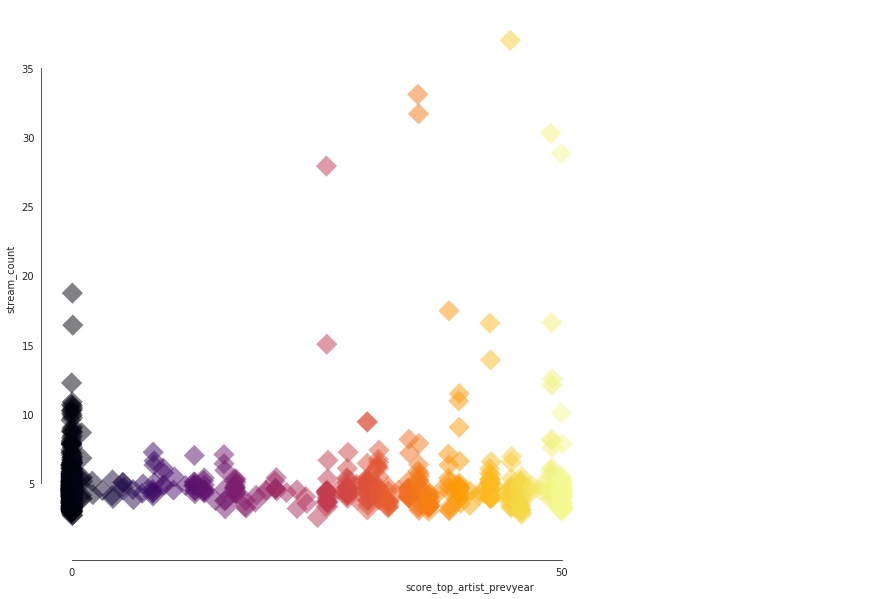

In [13]:
fig, ax = plt.subplots(figsize = (15,10))
sns.set_style('white')
sns.stripplot( hiphop["score_top_artist_prevyear"], hiphop["stream_count"]/1000000,  palette= "inferno", size= 15, marker="D", edgecolor="white", alpha = .5)
ax.set(xlim = (-2,80), xticklabels=["0","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","", "","","","","","","","50"])
sns.despine(offset=10, trim=True)

#sns.boxplot( "stream_count", data = hiphop, orient = 'v')